# Comparative Analysis script of RTStruct Segmentations for Radiophysical Assessment

## Objective:
This project focuses on the systematic evaluation of automated and manual segmentations of brain metastases, utilizing RTStruct files. The primary objective is to assess the precision and similarity of machine-generated segmentations in comparison to those created manually by medical experts, with the goal of quantifying the accuracy of automated segmentations relative to expert standards.

Although not directly implementing RANO-BM criteria, this analysis complements the clinical use of these criteria by leveraging a suite of computational metrics to evaluate the segmentation quality. Metrics such as the Dice Similarity Coefficient, Jaccard Index, and 95th percentile Hausdorff Distance are employed to measure the overlap and boundary precision between the automated and expert segmentations. This project is part of a broader effort to standardize and improve radiological workflows, facilitating more efficient patient follow-ups in clinical practice and potentially reducing the time required for segmentation, particularly for brain metastases, which are a complex and heterogeneous challenge in oncology.

By addressing the limitations of traditional unidimensional measurement approaches in the RANO-BM criteria (which rely on the largest diameter), this project aims to propose more robust volumetric methods for evaluating tumor response to treatment. The ultimate goal is to refine the segmentation processes used in both clinical trials and routine care, contributing to a more accurate and standardized tumor assessment workflow.

**Methodology**:
I use a comprehensive suite of spatial, statistical, and intensity metrics to assess segmentation accuracy and similarity:

- **Spatial Overlap and Distance Metrics**:
  - **Dice Similarity Coefficient (DSC)**: Measures the overlap between two volumes, providing a statistical validation of segmentation precision.
  - **Jaccard Index**: Quantifies the similarity and diversity between sample sets, indicating the proportionate size of the intersection divided by the union of the sample sets.
  - **Mean Surface Distance (MSD)**: Calculates the average Euclidean distance between the surfaces of two volumes, offering insights into the contour accuracy.
  - **Volume Overlap Error (VOE)**: Represents the proportion of the total volume that is over-segmented or under-segmented relative to the reference, complementing the Dice coefficient by providing error rates.
  - **Hausdorff Distance (95th percentile)**: Measures the distance between the surface points of the segmented volumes, excluding the top 5% of the largest errors. This metric provides a more robust evaluation of the segmentation quality by focusing on the majority of points and reducing the influence of outliers, giving a more accurate representation of the model’s overall performance.
  - **Variation of Information (VI)**: Measures the amount of information lost and gained in the segmentation process, reflecting the complexity and precision of the information captured by the segmentation.
  - **Cosine Similarity**: Assesses the cosine angle between the multidimensional representations of the segmented volumes, useful for understanding the orientation and agreement in the segmented shapes.

- **Statistical Analysis of Volumes, Diameters, and Intensity Distributions**:
  - The volumes and maximum diameters of segmented ROIs (Regions of Interest) are extracted and statistically analyzed. Descriptive statistics (mean, median, standard deviation, minimum, maximum, and quartiles) are calculated to provide a comprehensive overview of the data distribution and central tendencies.
  - **Intensity Distribution Analysis**: For each ROI, the minimum, maximum, mean, and standard deviation of intensities are computed, along with higher-order statistical measures such as **skewness** and **kurtosis**. This provides insight into the distribution of pixel intensities within the segmented regions, highlighting asymmetry (skewness) and the presence of outliers or heavy tails (kurtosis).

**Data Handling**:
- The segmentation results, including both reference and generated RTStructs, are first converted from DICOM format into voxel arrays for computational analysis.

# Imports

In [1]:
import numpy as np
import os
from scipy.spatial.distance import cdist, directed_hausdorff
from sklearn.metrics import mutual_info_score
from dicompylercore import dicomparser
from sklearn.metrics.pairwise import cosine_similarity
from shapely.geometry import Polygon
import pandas as pd
from scipy.ndimage import distance_transform_edt, binary_fill_holes
import pydicom
from scipy.stats import kurtosis, skew
from skimage.draw import line
import matplotlib.pyplot as plt


In [ ]:
!pip3 install -r requirements.txt

# Configuration :

In [2]:
dicom_folder_path = 'IRM' # folder containing MR images
dicom_reference_rtstruct_path = 'official.dcm' # reference META RTSTRUCT file
dicom_generated_rtstruct_path = 'fromMetIA.dcm' # generated META RTSTRUCT file
#dicom_generated_rtstruct_path = 'rtss2.dcm'
rois_to_ignore_original = [] # rois qu'on ne veut pas analyser dans le rtstruct de référence (pour la similarité only)
rois_to_ignore_generated = [] # rois qu'on ne veut pas analyser dans le rtstruct généré (pour la similarité only)

# Launch this script 

In [3]:
######################################################################################################################################@
################################################################# Metrics ########################################################## 
######################################################################################################################################@
def dice_coefficient(volume1, volume2):
    """
    Calcul de l'indice de Dice entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Indice de Dice.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    
    if size1 + size2 == 0:
        return 1.0  # si les deux volumes sont vides bas logiquement le dice est de 1
    return (2. * intersection) / (size1 + size2)

def mean_surface_distance(volume1, volume2):
    """
    Calcul de la distance moyenne des surfaces entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Distance moyenne des surfaces.
    """
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    
    if len(points1) == 0 or len(points2) == 0:
        return np.inf  # si l'un des volumes est vide, retourne infini
    
    d1 = cdist(points1, points2, metric='euclidean')
    d2 = cdist(points2, points1, metric='euclidean')
    
    msd1 = np.mean(np.min(d1, axis=1))
    msd2 = np.mean(np.min(d2, axis=1))
    
    return (msd1 + msd2) / 2

def volume_overlap_error(volume1, volume2):
    """
    Calcul de l'erreur de chevauchement entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Erreur de chevauchement.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    union = np.sum((volume1 > 0) | (volume2 > 0))
    
    if union == 0:
        return 0.0  # si l'union est vide, aucune erreur
    
    return 1 - (intersection / union)

def hausdorff_distance_95(volume1, volume2):
    """
    Calcul de la distance de Hausdorff au 95e percentile entre deux volumes binaires. (exclusion des outliers 5%)
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Distance de Hausdorff au 95e percentile.
    """
    points1 = np.argwhere(volume1 > 0)
    points2 = np.argwhere(volume2 > 0)
    
    if len(points1) == 0 or len(points2) == 0:
        return np.inf  # si l'un des volumes est vide, retourne infini
    
    # calculer toutes les distances entre les points de surface des deux volumes
    distances1_to_2 = cdist(points1, points2)
    distances2_to_1 = cdist(points2, points1)
    
    # calculer le 95e percentile des distances
    hd_95_1_to_2 = np.percentile(np.min(distances1_to_2, axis=1), 95)
    hd_95_2_to_1 = np.percentile(np.min(distances2_to_1, axis=1), 95)
    
    return max(hd_95_1_to_2, hd_95_2_to_1)

def jaccard_index(volume1, volume2):
    """
    Calcul de l'indice de Jaccard entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Indice de Jaccard.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    union = np.sum((volume1 > 0) | (volume2 > 0))
    
    if union == 0:
        return 1.0  # si les deux volumes sont vides, l'indice de Jaccard est maximal
    
    return intersection / union

def tanimoto_coefficient(volume1, volume2):
    """
    Calcul du coefficient de Tanimoto entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Coefficient de Tanimoto.
    """
    intersection = np.sum((volume1 > 0) & (volume2 > 0))
    size1 = np.sum(volume1 > 0)
    size2 = np.sum(volume2 > 0)
    
    if size1 + size2 - intersection == 0:
        return 1.0  # si les deux volumes sont vides ou identiques
    
    return intersection / (size1 + size2 - intersection)

def variation_of_information(volume1, volume2):
    """
    Calcul de la variation de l'information entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Variation de l'information.
    """
    volume1_flat = volume1.flatten()
    volume2_flat = volume2.flatten()
    
    h1 = mutual_info_score(volume1_flat, volume1_flat)
    h2 = mutual_info_score(volume2_flat, volume2_flat)
    mi = mutual_info_score(volume1_flat, volume2_flat)
    
    return h1 + h2 - 2 * mi

def cosine_similarity_3d(volume1, volume2):
    """
    Calcul de la similarité cosinus entre deux volumes binaires.
    
    Args:
        volume1 (numpy array): Premier volume 3D binaire.
        volume2 (numpy array): Deuxième volume 3D binaire.
        
    Returns:
        float: Similarité cosinus.
    """
    volume1_flat = volume1.flatten().reshape(1, -1)
    volume2_flat = volume2.flatten().reshape(1, -1)
    
    return cosine_similarity(volume1_flat, volume2_flat)[0][0]




def similarity_metrics(volume1, volume2):
    dsc = dice_coefficient(volume1, volume2)
    msd = mean_surface_distance(volume1, volume2)
    voe = volume_overlap_error(volume1, volume2)
    hd = hausdorff_distance_95(volume1, volume2)
    ji = jaccard_index(volume1, volume2) 
    tc = tanimoto_coefficient(volume1, volume2)
    vi = variation_of_information(volume1, volume2)
    cs = cosine_similarity_3d(volume1, volume2)
    
    return {
        'Dice Similarity Coefficient': dsc,
        'Mean Surface Distance': msd,
        'Volume Overlap Error': voe,
        'Hausdorff Distance': hd,
        'Jaccard Index': ji,
        'Tanimoto Coefficient': tc,
        'Variation of Information': vi,
        'Cosine Similarity': cs
    }

######################################################################################################################################@
################################################################# Load data ########################################################## 
######################################################################################################################################@
def load_dicom_files(directory):
    """
    Charge tous les fichiers DICOM d'un répertoire.
    
    Args:
        directory (str): Le chemin du répertoire contenant les fichiers DICOM.
        
    Returns:
        list: Une liste d'objets pydicom représentant les fichiers DICOM.
    """
    dicom_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.dcm'):
                filepath = os.path.join(root, file)
                dicom_files.append(pydicom.dcmread(filepath))
    dicom_files.sort(key=lambda x: int(x.InstanceNumber)) # ESSENTIEL pour l'ordre des slices
    return dicom_files

def read_dicom_rtstruct(filepath, rois_to_ignore=None, is_original=True):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    
    # verif que le fichier est un RT Structure Set
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour, structure in zip(contour_data, structures):
        roi_name = structure.ROIName

        # ignorer les ROIs dont le nom est dans la liste rois_to_ignore
        if roi_name in rois_to_ignore:
            print(f"ROI {roi_name} ignorée.")
            continue 
        
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours

def convert_contours_to_voxel_space(contours, dicom_files):
    """
    Convertit les coordonnées des contours en coordonnées de voxels.
    
    Args:
        contours (list): Liste des contours.
        dicom_files (list): Liste des fichiers DICOM.
        
    Returns:
        list: Liste des contours convertis en coordonnées de voxels.
    """
    pixel_spacing = dicom_files[0].PixelSpacing
    slice_thickness = dicom_files[0].SliceThickness
    image_position_patient = dicom_files[0].ImagePositionPatient

    contours_voxel_space = []

    for contour in contours:
        voxel_contour = []
        for point in contour:
            x_mm, y_mm, z_mm = point
            x_voxel = int((x_mm - image_position_patient[0]) / pixel_spacing[0])
            y_voxel = int((y_mm - image_position_patient[1]) / pixel_spacing[1])
            z_voxel = int((z_mm - image_position_patient[2]) / slice_thickness)
            voxel_contour.append((x_voxel, y_voxel, z_voxel))
        contours_voxel_space.append(np.array(voxel_contour))
    
    return contours_voxel_space



######################################################################################################################################@
# New : Les fonctions que j'ai déjà implémenté mais en version dictionnaire pour faciliter la manipulation des données 

def read_dicom_rtstruct_dict(filepath):
    ds = pydicom.dcmread(filepath)
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    contours = {}
    for i, roi_contour in enumerate(ds.ROIContourSequence):
        contour_points = []
        for contour_sequence in roi_contour.ContourSequence:
            points = contour_sequence.ContourData
            num_points = len(points) // 3
            points = np.array(points).reshape(num_points, 3)
            contour_points.append(points)
        contours[f'ROI_{i+1}'] = contour_points
    
    return contours

def convert_contours_to_voxel_space_dict(contours, dicom_files):
    pixel_spacing = dicom_files[0].PixelSpacing
    slice_thickness = dicom_files[0].SliceThickness
    image_position_patient = dicom_files[0].ImagePositionPatient

    contours_voxel_space = {}
    for roi_name, contour_list in contours.items():
        voxel_contour_list = []
        for contour in contour_list:
            voxel_contour = []
            for point in contour:
                x_mm, y_mm, z_mm = point
                x_voxel = int((x_mm - image_position_patient[0]) / pixel_spacing[0])
                y_voxel = int((y_mm - image_position_patient[1]) / pixel_spacing[1])
                z_voxel = int((z_mm - image_position_patient[2]) / slice_thickness)
                voxel_contour.append((x_voxel, y_voxel, z_voxel))
            voxel_contour_list.append(np.array(voxel_contour))
        contours_voxel_space[roi_name] = voxel_contour_list
    
    return contours_voxel_space

######################################################################################################################################@

import numpy as np
from scipy.ndimage import binary_fill_holes
from skimage.draw import line

def remplir_contours_avec_lignes(volume, contour):
    """
    Remplit les contours en traçant des lignes entre les points les plus proches du contour.
    
    Args:
        volume (numpy array): Volume 3D dans lequel tracer les lignes.
        contour (numpy array): Coordonnées des points du contour.
        
    Returns:
        volume: Volume avec les lignes tracées.
    """
    for i in range(len(contour) - 1):
        x1, y1, z1 = map(int, contour[i])
        x2, y2, z2 = map(int, contour[i + 1])

        # si le point est sur la même slice
        if z1 == z2:
            rr, cc = line(x1, y1, x2, y2)  # tracé de ligne entre deux points
            volume[rr, cc, z1] = 1  # rempli la ligne dans la slice correspondante

    # ferme le contour en reliant le dernier point au premier
    x1, y1, z1 = map(int, contour[-1])
    x2, y2, z2 = map(int, contour[0])
    
    if z1 == z2:
        rr, cc = line(x1, y1, x2, y2)
        volume[rr, cc, z1] = 1
    
    return volume

def contours_to_volume(contours, shape):
    """
    Convertit une liste de contours en un volume 3D binaire, en reliant les points de contour
    avec des lignes droites et en remplissant les trous avec binary_fill_holes.
    """
    volume = np.zeros(shape, dtype=np.uint8)

    # rempli le volume avec les contours en traçant des lignes
    for contour in contours:
        volume = remplir_contours_avec_lignes(volume, contour)
    
    # rempli des trous dans chaque slice avec binary_fill_holes
    for z in range(volume.shape[2]):
        slice_2d = volume[:, :, z]
        volume[:, :, z] = binary_fill_holes(slice_2d).astype(np.uint8)

    return volume

def extract_roi_info(rtstruct, dicom_series):

    dicom_series.sort(key=lambda x: int(x.InstanceNumber))
    # creer une map des positions de slices à leurs indices
    slice_positions = {round(dcm.ImagePositionPatient[2], 2): i+1 for i, dcm in enumerate(dicom_series)}

    # print les informations de Pixel Spacing, Slice Thickness, et Image Orientation pour le premier DICOM de la série
    pixel_spacing = dicom_series[0].PixelSpacing if hasattr(dicom_series[0], 'PixelSpacing') else "Non défini"
    slice_thickness = dicom_series[0].SliceThickness if hasattr(dicom_series[0], 'SliceThickness') else "Non défini"
    image_orientation = dicom_series[0].ImageOrientationPatient if hasattr(dicom_series[0], 'ImageOrientationPatient') else "Non défini"
    image_position = dicom_series[0].ImagePositionPatient if hasattr(dicom_series[0], 'ImagePositionPatient') else "Non défini"
    
    print(f"Pixel Spacing: {pixel_spacing}")
    print(f"Slice Thickness: {slice_thickness}")
    print(f"Image Orientation (Patient): {image_orientation}")
    print(f"Image Position (Patient): {image_position}")

    rtstruct_infos = {
        "PatientName": rtstruct.PatientName,
        "PatientID": rtstruct.PatientID,
        "PatientBirthDate": rtstruct.PatientBirthDate,
        "PatientSex": rtstruct.PatientSex,
        "StudyDate" : rtstruct.StudyDate,
        "StudyInstanceUID" : rtstruct.StudyInstanceUID
    }
    # charger le fichier RTStruct avec dicompyler-core
    rtstruct = dicomparser.DicomParser(rtstruct)

    # extraire les structures
    structures = rtstruct.GetStructures()

    #  pour calculer le diamètre d'un ROI
    def calculate_diameter(contour):
        max_distance = 0
        for i in range(len(contour)):
            for j in range(i + 1, len(contour)):
                distance = np.linalg.norm(np.array(contour[i]) - np.array(contour[j]))
                if distance > max_distance:
                    max_distance = distance
        return max_distance

    #  pour calculer le volume d'un ROI
    def calculate_volume(coords, thickness):
        volume = 0
        for z in coords.keys():
            contours = coords[z]
            for contour in contours:
                if len(contour['data']) >= 4:
                    polygon = Polygon(contour['data'])
                    volume += polygon.area * thickness
        return volume / 1000  # Convertir en cm³

    # init le dictionnaire de résultats
    roi_info = {}

    # parcourir les structures et extraire les informations
    for roi_number, roi_data in structures.items():
        roi_name = roi_data['name']
        roi_number = roi_data['id']
        # Obtenir les coordonnées des contours
        coords = rtstruct.GetStructureCoordinates(roi_number)
        
        #  le volume
        thickness = dicomparser.DicomParser.CalculatePlaneThickness(rtstruct, coords)
        volume = calculate_volume(coords, thickness)
        
        # le diamètre maximal
        contours = []
        contour_slice_indices = []
        for plane in coords.values():
            for contour in plane:
                contours.append(contour['data'])
                z_pos = round(contour['data'][0][2], 2)
                if z_pos in slice_positions:
                    contour_slice_indices.append(slice_positions[z_pos])
        
        diameters = [calculate_diameter(contour) for contour in contours]
        nb_dicoms = len(dicom_series)
        
        # get les slices de début et de fin
        start_slice = nb_dicoms - max(contour_slice_indices) if contour_slice_indices else None
        end_slice = nb_dicoms - min(contour_slice_indices) if contour_slice_indices else None

        # add les informations au dictionnaire
        roi_info[roi_name] = {
            "roiNumber" : roi_number,
            "diameter_max": max(diameters),
            "volume_cm3": volume,
            "start_slice": start_slice,
            "end_slice": end_slice,
            "color": str(roi_data.get('color', (0, 0, 255)))
        }

    return roi_info, rtstruct_infos



######################################################################################################################################@
# New : Calcul des intensités des rois :
######################################################################################################################################@

def remplir_contours_en_connectant_points(array_2d, contours):
    """
    Remplit les contours en connectant les points les plus proches avec des lignes droites.
    """
    mask = np.zeros_like(array_2d, dtype=np.bool_)

    # pour connecter les points de contour par des lignes droites
    for i in range(len(contours) - 1):
        # prend comme entrée les coordonnées des points de départ et d’arrivée (en termes de x et y) et renvoie deux tableaux, rr et cc, qui sont les indices des lignes et des colonnes que la ligne traverse dans la grille de pixels.
        rr, cc = line(contours[i][1], contours[i][0], contours[i+1][1], contours[i+1][0])
        mask[rr, cc] = True # on def les pixels de cette ligne en tant que du masque (True)

    # ferme le contour en reliant le dernier point au premier par sécurité
    rr, cc = line(contours[-1][1], contours[-1][0], contours[0][1], contours[0][0])
    mask[rr, cc] = True

    # rempli les trous à l'intérieur des contours avec scipy.ndimage :
    mask_rempli = binary_fill_holes(mask)
    return mask_rempli

def appliquer_masque_sur_irm(dicom_files, contours_voxel_space):
    """
    Extrait uniquement les parties de l’image qui se trouvent à l’intérieur des contours pour chaque ROI.
    """
    volumes_roi = {}
    image_shape = dicom_files[0].pixel_array.shape
    num_slices = len(dicom_files)
    
    for roi_name, voxel_contours in contours_voxel_space.items():
        print(f"Traitement du ROI : {roi_name}")
        volume_irm_roi = np.zeros((image_shape[0], image_shape[1], num_slices), dtype=np.float32)
        
        for z, dicom_data in enumerate(dicom_files):
            image = dicom_data.pixel_array.astype(np.float32)
            masque_final = np.zeros_like(image, dtype=np.bool_)
            
            for contour in voxel_contours:
                # on extrait les points du contour qui se trouvent sur la slice actuelle (z)
                slice_contour = contour[contour[:, 2] == z] 
                # si y a des points de contours sur cette slice :
                if len(slice_contour) > 0:
                    # alors je créer un masque binaire où les régions à l’intérieur des contours sont remplies
                    mask_rempli = remplir_contours_en_connectant_points(image, slice_contour[:, :2].astype(int))
                    # on combine (opération logique OR) le masque actuel avec les masques remplis pour cette slice, afin d’obtenir le masque final pour l’ensemble des contours du ROI sur cette coupe.
                    masque_final = masque_final | mask_rempli
            
            # applique le masque sur l'image IRM pour la slice courante
            image_filtre = np.where(masque_final, image, 0)
            volume_irm_roi[:, :, z] = image_filtre
        
        # stock le volume IRM filtré dans le dictionnaire
        volumes_roi[roi_name] = volume_irm_roi
    
    return volumes_roi

def calculer_statistiques_intensite_pandas(volumes_roi):
    stats_dict = {
        'ROI': [],
        'Min Intensity': [],
        'Max Intensity': [],
        'Mean Intensity': [],
        'Std Intensity': [],
        'Kurtosis': [],
        'Skewness': []
    }
    
    for roi_name, volume in volumes_roi.items():
        # extractation des valeurs non nulles
        non_zero_values = volume[volume > 0]
        
        # calcul des statistiques d'intensité
        min_intensity = np.min(non_zero_values)
        max_intensity = np.max(non_zero_values)
        mean_intensity = np.mean(non_zero_values)
        std_intensity = np.std(non_zero_values)
        kurtosis_value = kurtosis(non_zero_values)
        skewness_value = skew(non_zero_values)
        
        # Ajouter les statistiques au dictionnaire
        stats_dict['ROI'].append(roi_name)
        stats_dict['Min Intensity'].append(min_intensity)
        stats_dict['Max Intensity'].append(max_intensity)
        stats_dict['Mean Intensity'].append(mean_intensity)
        stats_dict['Std Intensity'].append(std_intensity)
        stats_dict['Kurtosis'].append(kurtosis_value)
        stats_dict['Skewness'].append(skewness_value)
    
    # Convertir le dictionnaire en DataFrame
    df_stats = pd.DataFrame(stats_dict)
    
    return df_stats

In [ ]:
# charger les fichiers DICOM et les contours
dicom_files = load_dicom_files(dicom_folder_path)

rows = dicom_files[0].Rows
columns = dicom_files[0].Columns
len_dicoms = len(dicom_files)

shape = (rows, columns, len_dicoms)

# lire les contours du fichier RTStruct
contours_rtstruct_original = read_dicom_rtstruct(dicom_reference_rtstruct_path, rois_to_ignore_original, is_original=True)
contours_rtstruct_generated = read_dicom_rtstruct(dicom_generated_rtstruct_path, rois_to_ignore_generated, is_original=False)

# convertir les coordonnées des contours en coordonnées de voxels
contours_voxel_space_original = convert_contours_to_voxel_space(contours_rtstruct_original, dicom_files)
contours_voxel_space_generated = convert_contours_to_voxel_space(contours_rtstruct_generated, dicom_files)

# convertir les contours en volumes 3D
volume_original = contours_to_volume(contours_voxel_space_original, shape)
volume_generated = contours_to_volume(contours_voxel_space_generated, shape)

#-- pour verifier si nos contours sont bien remplis pour la théorie des ensembles pour les mesures de similarité
def plot_volume_slice(volume, slice_idx, title="Slice du volume"):
    plt.imshow(volume[:, :, slice_idx], cmap='gray')
    plt.title(f"{title} - Slice {slice_idx}")
    plt.show()

slice_index = 172  # choisir une tranche a tester ici la grosse metastase   # len(dicoms) -  le numero de slice de metia ici ct la slice 208 - 36 = 172
plot_volume_slice(volume_original, slice_index, "Slice du volume original")
plot_volume_slice(volume_generated, slice_index, "Slice du volume généré")
#--

print("Informations extraites du RTStruct original:")
rtstruct_pydicom_original = pydicom.dcmread(dicom_reference_rtstruct_path)
meta_infos, rtstruct_infos = extract_roi_info(rtstruct_pydicom_original, dicom_files)

for roi_name, info in meta_infos.items():
    print(f"{roi_name} : Diamètre max: {info['diameter_max']:.2f} mm, Volume: {info['volume_cm3']:.2f} cm³, Slice de début: {info['start_slice']} ,Slice de fin: {info['end_slice']}, couleur : {info['color']}")

print() 

rtstruct_pydicom_generated = pydicom.dcmread(dicom_generated_rtstruct_path)
print("Informations extraites du RTStruct généré:")

meta_infos_generated, rtstruct_infos_generated = extract_roi_info(rtstruct_pydicom_generated, dicom_files)

for roi_name, info in meta_infos_generated.items():
    print(f"{roi_name} : Diamètre max: {info['diameter_max']:.2f} mm, Volume: {info['volume_cm3']:.2f} cm³, Slice de début: {info['start_slice']} ,Slice de fin: {info['end_slice']}, couleur : {info['color']}")

# calcul des métriques de similarité sans gap_error
metrics = similarity_metrics(volume_original, volume_generated)

# print des résultats de similarité
for metric, value in metrics.items():
    print(f'{metric}: {value}')

######################################################################################################################################@

# conversion des meta_infos en DataFrame pour statistiques et export
df_original = pd.DataFrame.from_dict(meta_infos, orient='index')
df_generated = pd.DataFrame.from_dict(meta_infos_generated, orient='index')

stats_original = df_original.describe()
stats_generated = df_generated.describe()

# combiner les statistiques des deux RTStruct (original et généré)
combined_stats = pd.concat([stats_original, stats_generated], axis=1, keys=['RTStruct Original', 'RTStruct Generated'])

print(combined_stats)

# exporter les statistiques
combined_stats.to_excel("roi_statistics_comparison.xlsx")
combined_stats.to_csv("roi_statistics_comparison.csv")

# export des métriques de similarité
df_metrics = pd.DataFrame.from_dict(metrics, orient='index').T  # Convertir les métriques en DataFrame
df_metrics.to_excel("similarity_metrics.xlsx")
df_metrics.to_csv("similarity_metrics.csv")

######################################################################################################################################@

# calcul des volumes filtrés pour l'intensité pour les ROIs de référence
contours_original = read_dicom_rtstruct_dict(dicom_reference_rtstruct_path)
contours_voxel_space_original = convert_contours_to_voxel_space_dict(contours_original, dicom_files)
volumes_roi_original = appliquer_masque_sur_irm(dicom_files, contours_voxel_space_original)

# calcul des volumes filtrés pour l'intensité pour les ROIs générés par l'IA
contours_generated = read_dicom_rtstruct_dict(dicom_generated_rtstruct_path)
contours_voxel_space_generated = convert_contours_to_voxel_space_dict(contours_generated, dicom_files)
volumes_roi_generated = appliquer_masque_sur_irm(dicom_files, contours_voxel_space_generated)

######################################################################################################################################@

# calcul des statistiques d'intensité pour les ROIs de référence
df_stats_original = calculer_statistiques_intensite_pandas(volumes_roi_original)

# calcul des statistiques d'intensité pour les ROIs générés par l'IA
df_stats_generated = calculer_statistiques_intensite_pandas(volumes_roi_generated)

# rename les colonnes pour différencier les deux DataFrames
df_stats_original = df_stats_original.set_index('ROI').rename(columns=lambda x: f'{x} (Original)')
df_stats_generated = df_stats_generated.set_index('ROI').rename(columns=lambda x: f'{x} (Generated)')

# concatener les statistiques des deux DataFrames
df_combined_stats = pd.concat([df_stats_original, df_stats_generated], axis=1)

# exportation des résultats en CSV et Excel
df_combined_stats.to_csv("roi_intensity_statistics_comparison.csv")
df_combined_stats.to_excel("roi_intensity_statistics_comparison.xlsx")

print(df_combined_stats)

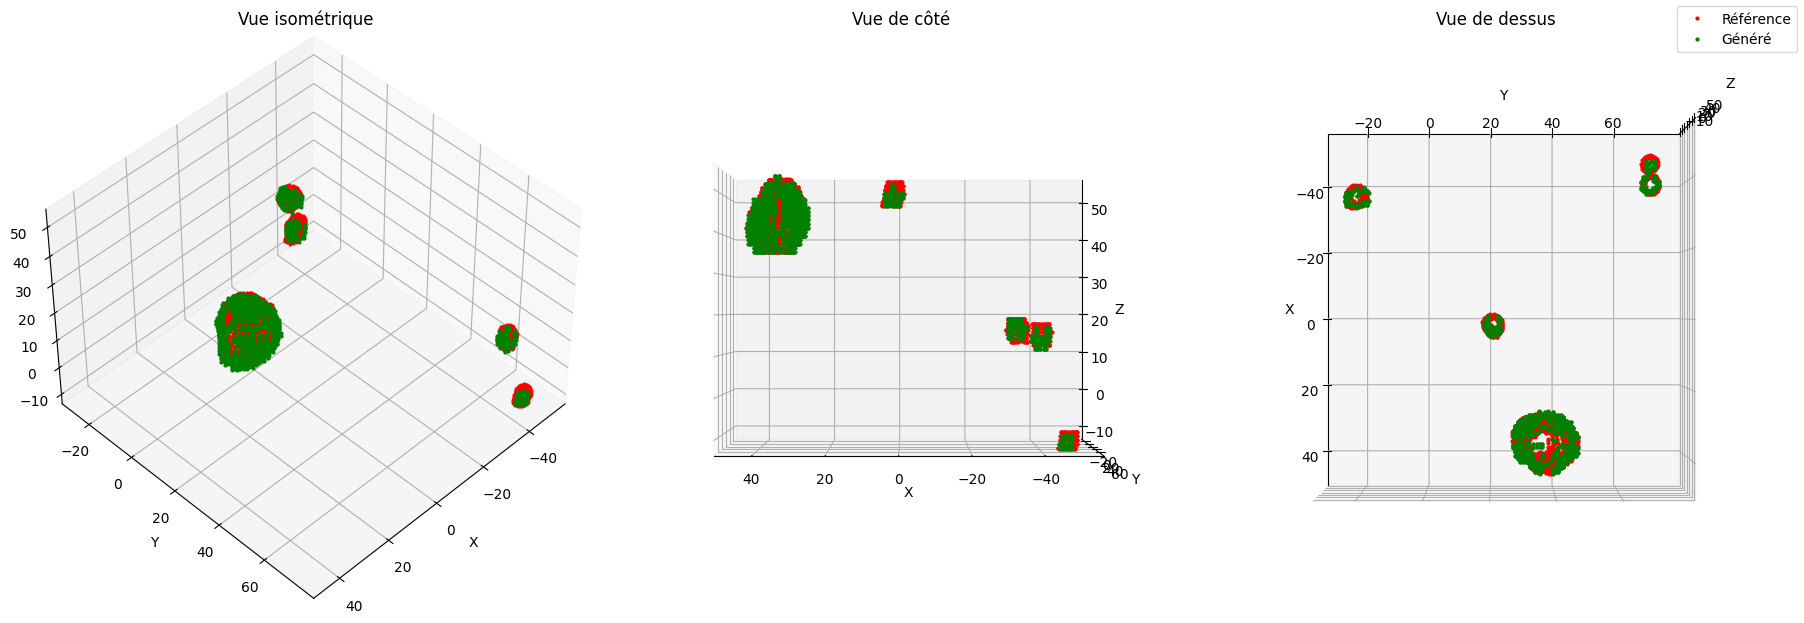

In [15]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_dicom_rtstruct(filepath):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour in contour_data:
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours

def plot_3d_contours_multiple_views(contours_ref, contours_gen):
    fig = plt.figure(figsize=(18, 6))
    
    views = [(45, 45), (90, 0), (0, 90)]
    titles = ['Vue isométrique', 'Vue de côté', 'Vue de dessus']
    
    for i, (azim, elev) in enumerate(views):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        for contour in contours_ref:
            x = contour[:, 0]
            y = contour[:, 1]
            z = contour[:, 2]
            ax.plot(x, y, z, 'o', markersize=2, color='red', label='Référence' if contour is contours_ref[0] else "")

        for contour in contours_gen:
            x = contour[:, 0]
            y = contour[:, 1]
            z = contour[:, 2]
            ax.plot(x, y, z, 'o', markersize=2, color='green', label='Généré' if contour is contours_gen[0] else "")

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(titles[i])
        ax.view_init(elev=elev, azim=azim)
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()

dicom_reference_rtstruct_path = 'official.dcm'
dicom_generated_rtstruct_path = 'fromMetIA.dcm'

contours_original = read_dicom_rtstruct(dicom_reference_rtstruct_path)
contours_generated = read_dicom_rtstruct(dicom_generated_rtstruct_path)

plot_3d_contours_multiple_views(contours_original, contours_generated)

# Visualisation avec matplotlib pour vérifier que les masques sont bons pour le calcul des stats d'intensité

In [ ]:
def afficher_slices_avec_rois(volumes_roi, roi_type, num_slices):
    """
    Affiche les slices qui comportent des ROIs non vides en ajustant le numéro de la slice.
    
    Args:
        volumes_roi (dict): Dictionnaire contenant les volumes pour chaque ROI.
        roi_type (str): Type de ROI ('Original' ou 'Generated').
        num_slices (int): Nombre total de slices dans la série DICOM.
    """
    for roi_name, volume in volumes_roi.items():
        print(f"Affichage des slices pour {roi_name} ({roi_type}):")
        
        for z in range(volume.shape[2]):
            # verif si la slice contient des valeurs non nulles
            if np.any(volume[:, :, z] > 0):
                slice_number = num_slices - z
                plt.figure(figsize=(6, 6))
                plt.imshow(volume[:, :, z], cmap='gray')
                plt.title(f'{roi_name} ({roi_type}) - Slice {slice_number}')
                plt.axis('on')
                plt.show()

print("Slices avec des ROIs - RTStruct Original:")
afficher_slices_avec_rois(volumes_roi_original, "Original", len_dicoms)

print("\nSlices avec des ROIs - RTStruct Generated:")
afficher_slices_avec_rois(volumes_roi_generated, "Generated", len_dicoms)

# My miscellaneous experiments for do this job

In this project, we work with voxels, which are the smallest 3D units of measurement in medical imaging data such as DICOM files. Handling these voxels accurately is crucial because they represent specific volumetric information from the patient’s scans. Each voxel holds a defined size based on the resolution and spacing of the images, which varies depending on the acquisition settings of the imaging equipment. Misinterpreting or mishandling these voxel dimensions can lead to errors in the segmentation process, potentially affecting the volume calculations and the alignment between automated and manual segmentations.

The challenge lies in ensuring that both the automated and manual segmentations align perfectly at the voxel level. This requires careful attention to the DICOM metadata, such as pixel spacing and slice thickness, which are essential for reconstructing the 3D volume accurately. Any deviation in voxel interpretation could introduce significant discrepancies in the segmentation accuracy, especially in clinical applications where small differences can impact treatment decisions.

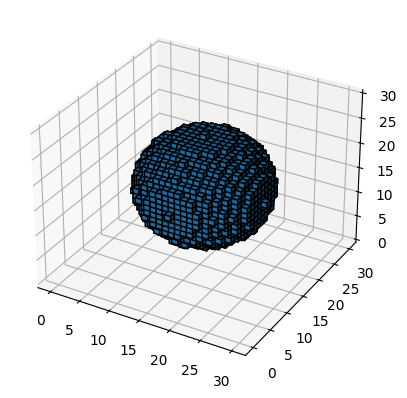

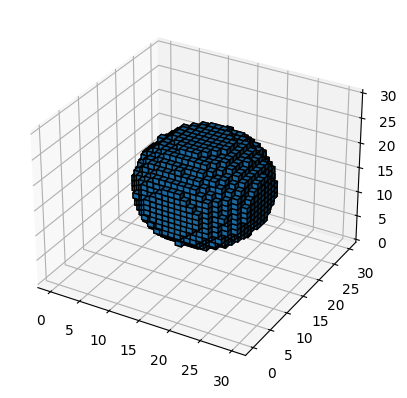

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_3d_volume(shape, sphere_radius):
    """
    Crée un volume 3D binaire avec des zéros partout et une sphère de 1 au milieu.
    """
    volume = np.zeros(shape, dtype=np.uint8)
    center = np.array(shape) // 2
    
    for x in range(shape[0]):
        for y in range(shape[1]):
            for z in range(shape[2]):
                if np.linalg.norm(np.array([x, y, z]) - center) <= sphere_radius:
                    volume[x, y, z] = 1
    
    return volume

def plot_3d_volume(volume):
    """
    Affiche le volume 3D en utilisant matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.voxels(volume, edgecolor='k')
    
    plt.show()

# Dimensions du volume 3D (par exemple, 30x30x30)
shape = (30, 30, 30)
# Rayon de la sphère au centre du volume
sphere_radius = 10

# Crée le volume 3D
volume1 = create_3d_volume(shape, sphere_radius)
volume2 = create_3d_volume(shape, sphere_radius - 0.1)

# Affiche le volume 3D
plot_3d_volume(volume1)
plot_3d_volume(volume2)


When using set-theory-based measures such as the Dice Similarity Coefficient or Jaccard Index, special care must be taken with the segmentation contours, as they often contain gaps or holes. These imperfections in the contours can lead to inaccurate calculations if not properly addressed. As seen in the image, gaps can occur between boundary points, which results in an incomplete surface representation.

To mitigate this, it is essential to connect the boundary points by drawing lines between them, effectively closing the gaps. Afterward, the interior surfaces must be filled to create solid masks. This step ensures that the set-theory-based metrics correctly reflect the true volume and shape of the segmented structure, providing more accurate overlap measurements between automated and manual segmentations.

Contour 0:
[[ 4.064895  22.80843   47.77951  ]
 [ 4.872766  22.13117   47.77951  ]
 [ 5.038352  21.1903    47.77951  ]
 [ 4.98927   20.37592   47.77951  ]
 [ 4.325519  19.64703   47.77951  ]
 [ 3.47629   19.37649   47.77951  ]
 [ 1.469513  19.22034   47.77951  ]
 [ 0.663972  19.44009   47.77951  ]
 [ 0.1556445 19.89163   47.77951  ]
 [-0.2176661 20.51037   47.77951  ]
 [-0.2619112 21.35265   47.77951  ]
 [ 0.2937662 22.33735   47.77951  ]
 [ 0.8349229 22.69546   47.77951  ]
 [ 1.766603  22.88464   47.77951  ]
 [ 2.978683  22.88169   47.77951  ]]

Contour 1:
[[ 5.032926   21.31103    48.77951   ]
 [ 4.715748   20.30418    48.77951   ]
 [ 4.477738   19.97147    48.77951   ]
 [ 3.88162    19.497      48.77951   ]
 [ 3.001421   19.21054    48.77951   ]
 [ 1.427195   19.12189    48.77951   ]
 [ 0.6355689  19.37739    48.77951   ]
 [-0.1920465  20.14381    48.77951   ]
 [-0.4030024  20.89533    48.77951   ]
 [-0.273221   21.70031    48.77951   ]
 [ 0.08243378 22.35151    48.77951   ]
 [ 0.50

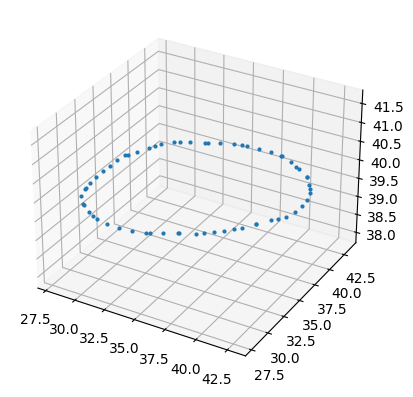

In [3]:
import pydicom
import numpy as np

def read_dicom_rtstruct(filepath):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    

    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour in contour_data:
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours


dicom_rtstruct_path = 'rtstruct.dcm'
contours = read_dicom_rtstruct(dicom_rtstruct_path)

for i, contour in enumerate(contours):
    print(f"Contour {i}:")
    print(contour)
    print()


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_contour(contour):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = contour[:, 0]
    y = contour[:, 1]
    z = contour[:, 2]
    
    ax.plot(x, y, z, 'o', markersize=2)
    plt.show()

# Afficher le premier contour pour exemple
if contours:
    plot_3d_contour(contours[34])


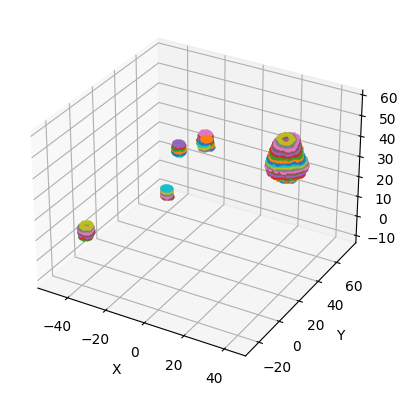

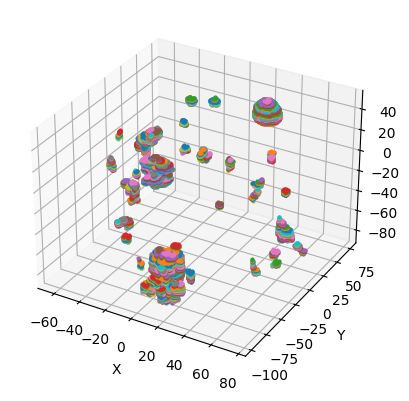

In [4]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_dicom_rtstruct(filepath):
    """
    Lit un fichier DICOM RTStruct et récupère les données comme un tableau numpy.
    """
    ds = pydicom.dcmread(filepath)
    
    if ds.Modality != 'RTSTRUCT':
        raise ValueError(f"Le fichier {filepath} n'est pas un fichier RT Structure Set.")
    
    structures = ds.StructureSetROISequence
    contour_data = ds.ROIContourSequence
    
    contours = []
    for roi_contour in contour_data:
        for contour_sequence in roi_contour.ContourSequence:
            contour_points = contour_sequence.ContourData
            num_points = len(contour_points) // 3
            points = np.array(contour_points).reshape(num_points, 3)
            contours.append(points)
    
    return contours

def plot_3d_contours(contours):
    """
    Affiche les contours 3D en utilisant matplotlib.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        z = contour[:, 2]
        ax.plot(x, y, z, 'o', markersize=2)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

dicom_rtstruct_path = 'rtstruct.dcm'
dicom_rtstruct_path_generated = 'rtstructGeneratedAl.dcm'
contours_original = read_dicom_rtstruct(dicom_rtstruct_path)
plot_3d_contours(contours)

contours_generated = read_dicom_rtstruct(dicom_rtstruct_path_generated)
plot_3d_contours(contours_generated)